# Learning as choosing a loss distribution

In machine learning, losses (or rewards) are the fundamental source of data-driven *feedback* that make learning algorithms work. Much of the research literature, both theoretical and applied, is centered around the design of *loss functions* (input: model candidate and data point, output: real value), with the tacit assumption that at training time, *individual losses will be summed* over to construct a final objective function to be optimized. This approach is the bedrock of traditional machine learning (also called empirical risk minimization), but the choice of summing or averaging over losses leads to tradeoffs (e.g., poor worst-case performance, weak high-probability guarantees, issues with fairness or privacy, etc.), meaning that naively averaging over losses might not lead to the outcomes we hope for at test time.

### What is this notebook about?

In this "explainer" notebook, rather than having loss function as our only degree of freedom, we take the loss function as *given*, and instead consider the transformation of a set of losses (or more generally, a loss distribution) to a real value as a key element of the learning algorithm design process. We call this transformation a "learning criterion", with the expected value or mean being the canonical choice of criterion, though we will go far beyond the mean in this explainer. Using simple, illustrated examples, our goal here is to show that paying attention to learning criteria can be fruitful, and that machine learning itself can be understood as selecting a loss distribution with desirable properties, noting that the criterion is tasked with encoding these properties. We introduce and visualize several classes of learning criteria, highlighting their traits under varying distributions, and discussing fundamental limitations that should be considered when designing such criteria.

This notebook is divided into three main sections.

1. Warmup: choosing a loss distribution
2. Quantifying and visualizing learning criteria
3. Fundamental limitations

The first section uses a simple one-variable linear regression task as an example to highlight the distinct nature of "loss function design" and "learning criterion design". In section 2, we then take detailed look at important classes of learning criteria, with lots of visual aids. Section 3 is slightly more advanced, and highlights unavoidable tradeoffs and potential pitfalls that arise when designing criteria. All the code for generating figures is available in this repository, and can be easily customized and modified.

### Who should read this?

We hope that anyone with an interest in the methodology of modern machine learning can get something out of this explainer. We have done our best to make the terminology accessible and the examples simple and transparent, but a certain degree of basic literacy is needed to really understand what is going on. Anyone who is familiar with how machine learning problems are formally formulated should have no issue. With that, let's dive in!

___

## 1. Warmup: choosing a loss distribution

To get us started with a simple example, we take a look at the well-known ["Belgium Phone Calls 1950-1973"](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/phones.html) dataset \[Ven02\]. We have normalized the "inputs" (horizontal axis) to take values between $0$ and $x_{\max}$, and the outputs (vertical axis) take values between $0$ and $y_{\max}$, with no normalization done. The exact maximum values used are not important for our discussion here, and the real-world context in which this data originally arose will be left abstract moving forward.

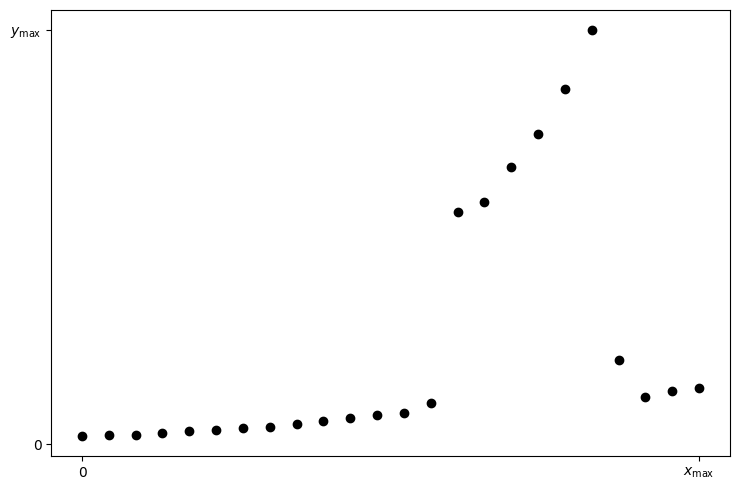

In [1]:
import numpy as np
from setup.utils import make_scatter, make_scatter_traintest, make_hist, test_data_linear, obj_leastmedloss
seed = 231782381787283786178263
rg = np.random.default_rng(seed=seed)

n = 24
X = np.linspace(0, 1, n).reshape((n,1))
X_padded = np.hstack([X, np.ones(X.shape, dtype=X.dtype)])
y = np.array([4.4, 4.7, 4.7, 5.9, 6.6, 7.3, 8.1, 8.8,
              10.6, 12.0, 13.5, 14.9, 16.1, 21.2, 119.0,
              124.0, 142.0, 159.0, 182.0, 212.0, 43.0,
              24.0, 27.0, 29.0]).reshape((n,1))
make_scatter(X=X, y=y)

When the task is "regression," i.e., prediction of the outputs based upon the inputs, the simplest and most traditional approach to this problem is *ordinary least squares* (OLS). Using the [SciPy implementation of OLS](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html), we arrive at the following regression line.

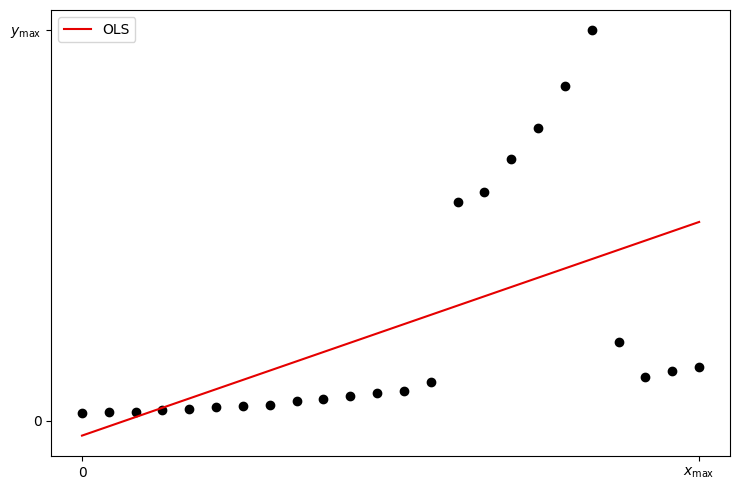

In [2]:
from scipy.linalg import lstsq

# Compute the OLS solution.
regline_ols, res_ols, rnk_ols, s_ols = lstsq(a=X_padded, b=y)

# Plot data with OLS solution.
make_scatter(X=X, y=y,
             lines=[(regline_ols[0], regline_ols[1])],
             colors=["xkcd:red"], styles=["solid"], labels=["OLS"])

How "good" is this OLS solution? From the perspective of finding a __linear__ predictor that minimizes the __average__ of the __squared prediction error__, then the OLS solution is of course *optimal*. When considering the performance of learning systems, however, it is not enough to consider only the data at hand; we also hope to achieve good prediction on new data, that is, *off-sample*. Let us consider two possible scenarios illustrated in the two plots below.

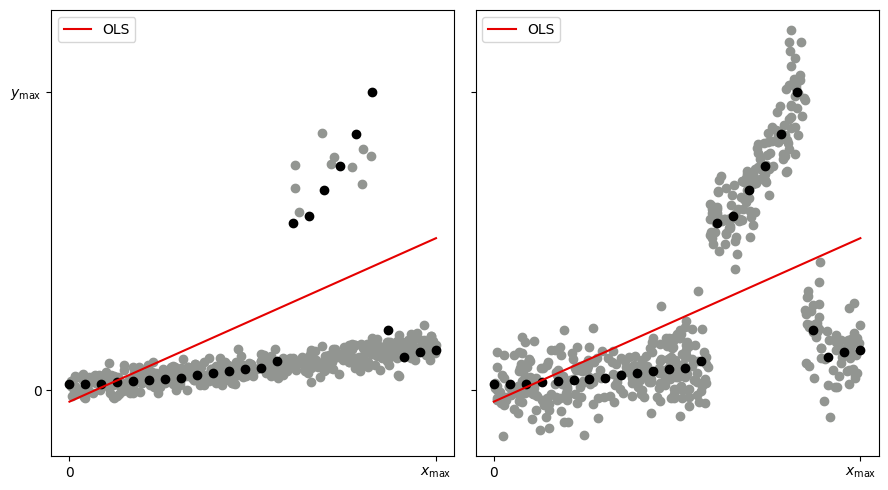

In [3]:
make_scatter_traintest(X=X, y=y, rg=rg,
                       lines=[(regline_ols[0], regline_ols[1])],
                       colors=["xkcd:red"], styles=["solid"], labels=["OLS"])

In both of these plots, the data we have access to now (at "training" time) is represented using black points, whereas gray points represent a hypothetical larger sample from an underlying data-generating process that we do not have access to (created artificially here for illustrative purposes). We may of course eventually have access to this data, i.e., at "test" time, but the essence of the learning problem is how well we can do at test time using the limited information available at training time. In the left-hand plot, the relationship between the inputs and outputs is essentially linear and slow-growing, with a few rare exceptions. On the other hand, in the right-hand plot, the true relationship appears to be rather non-linear.

### How "good" is the OLS solution?

With these two scenarios in mind, let us return to the question of how "good" the OLS solution is.

In the essentially linear scenario, we see that at test time, a different choice of regression line (smaller slope) would yield much better predictions on the vast majority of the data points; if the rare exceptions can be ignored, it is natural to be dissatisfied with the OLS solution. That is, the linear *model* is correct, but the output of the learning algorithm that we have called "OLS" is unsatisfactory.

On the other hand, in the non-linear scenario, one expects that the sharp upward trend is *not* a rare exception that can be ignored, but rather a fundamental non-linearity in the relationship between the inputs and outputs. In this case, while our linear model is very limited in its expressive power, given this model, the OLS solution itself is actually quite good.

To summarize, in the former scenario, the model is correct, but the learning algorithm is poor. In the latter scenario, the model is wrong, but the learning algorithm has done a good job. In this "explainer", we are interested in general principles for learning algorithm design (rather than model design), and we will proceed by considering how to modify the OLS algorithm within the confines of the essentially linear scenario.

### Initial strategy: clean the data

Since this dataset is small both in size and dimensionality, by plotting the data it is easy to identify the errant data points. If we manually remove the six points that deviate far from the slow-growth trend of the majority and run the OLS procedure on this smaller dataset, we end up with a very different predictor, shown using a dashed line in the plot below.

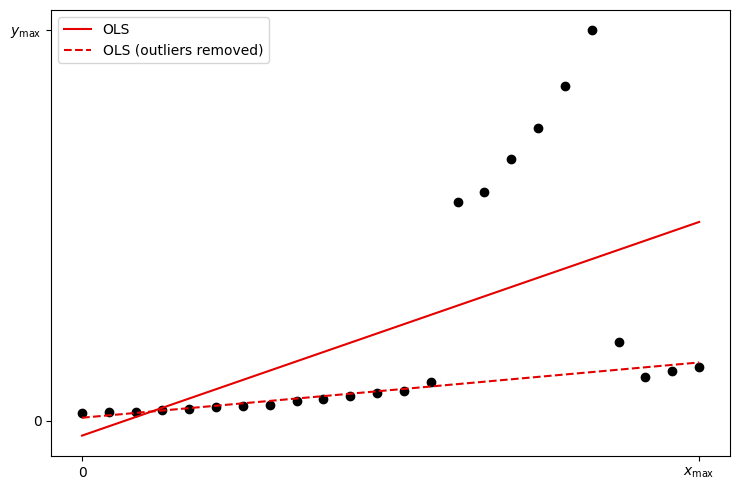

In [4]:
# OLS solution *without* the outlying points.
y_inlier_idx = y.reshape(-1) <= np.quantile(a=y.reshape(-1), q=0.75)
regline_removed, res_removed, rnk_removed, s_removed = lstsq(a=X_padded[y_inlier_idx,:],
                                                             b=y[y_inlier_idx,:])

# Plot both the original OLS solution and the OLS solution found after removing outliers.
make_scatter(X=X, y=y,
             lines=[(regline_ols[0], regline_ols[1]), (regline_removed[0], regline_removed[1])],
             colors=["xkcd:red", "xkcd:red"],
             styles=["solid", "dashed"],
             labels=["OLS", "OLS (outliers removed)"])

While manual removal of errant points does work in very simple settings such as this one, larger datasets with more inputs makes the identification of "outliers" a highly non-trivial problem, and other approaches typically need to be considered.

### Another typical strategy: changing the loss function

In considering an alternative to the OLS algorithm, let us recall its traits, as summarized in the following sentence given a few paragraphs back.

> From the perspective of finding a __linear__ predictor that minimizes the __average__ of the __squared prediction error__, then the OLS solution is of course *optimal*.

We have underlined key terms for a reason; these three points characterize the OLS solution plotted earlier. To make things more precise, let us introduce a bit of formal notation. The first term ("__linear__") relates to model design, and means that we will use a predictor of the form $h(x) = ax + b$, where $a$ and $b$ are arbitrary real values. Using $\mathcal{H}$ as general-purpose notation for our model (or "hypothesis class"), here we have $\mathcal{H} = \{x \mapsto ax + b: a, b \in \mathbb{R}\}$. As for the other two terms ("__average__", "__squared prediction error__"), these relate to algorithm design, and they mean that the learning algorithm returns a solution to the optimization task

\begin{align}
\min_{h \in \mathcal{H}} \, \frac{1}{n}\sum_{i=1}^{n}\ell(h;\mathsf{X}_{i},\mathsf{Y}_{i})
\end{align}

where the loss function takes the form $\ell(h;x,y)=(h(x)-y)^{2}$ and $\{(\mathsf{X}_{i},\mathsf{Y}_{i}): i=1,\ldots,n\}$ denotes the data sample available at training time. When $\mathcal{H}$ is a linear model, this optimization problem is very simple; it reduces to solving a system of linear equations. This means that in implementing the OLS procedure, one can leverage very efficient linear algebra software libraries. While this simplicity is appealing, recall that we were *dissatisfied* with the OLS solution in the linear scenario, and manual data cleaning is a chore we would like to avoid.

One of the most common alternative approaches is that of *least absolute deviations* (LAD); this procedure is identical to the OLS procedure described, except that a different loss function is used, namely the absolute error $\ell(h;x,y) = \lvert h(x)-y \rvert$. Using the [LAD implementation in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html), one gets the following predictor (drawn using a solid blue line).

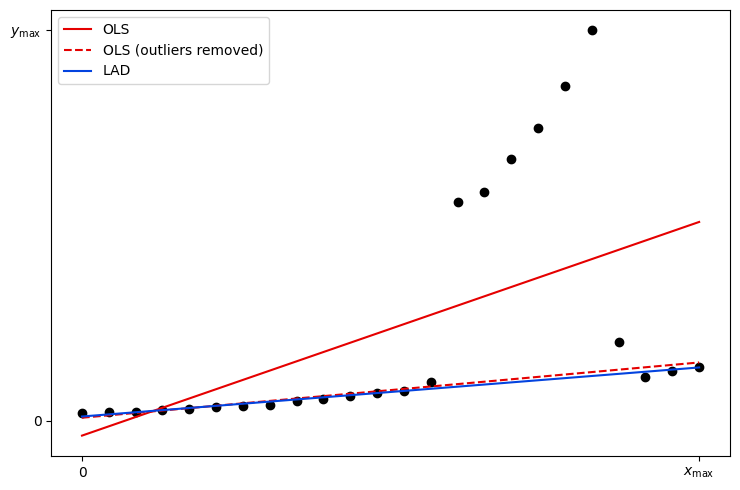

In [5]:
from sklearn.linear_model import QuantileRegressor

# Compute the LAD solution.
qr = QuantileRegressor(quantile=0.5, alpha=0.0, fit_intercept=True)
qr_fitted = qr.fit(X, y.reshape(-1))
regline_lad = [qr_fitted.coef_.item(), qr_fitted.intercept_]

# Plot the LAD solution along with the other two candidates considered earlier.
make_scatter(X=X, y=y,
             lines=[(regline_ols[0], regline_ols[1]),
                    (regline_removed[0], regline_removed[1]),
                    (regline_lad[0], regline_lad[1])],
             colors=["xkcd:red", "xkcd:red", "xkcd:blue"],
             styles=["solid", "dashed", "solid"],
             labels=["OLS", "OLS (outliers removed)", "LAD"])

Note that the outputs of the algorithms "vanilla LAD" and "OLS after removing outliers" are very similar, but the former gives us such a predictor without having to specify outliers manually. On the other hand, the "vanilla OLS" and "vanilla LAD" outputs are clearly very different.

Based on these observations, one might be inclined to make the following broad conclusion: "LAD is insensitive to outliers." Indeed, for this particular data set, the output of LAD *is* insensitive to the outlying data points. However, is this a property we should expect in general? As highlighted earlier, both OLS and LAD are defined in terms of optimizing the __average__ loss. Since the objective function puts the same weight on every loss value, an insensitivity to outliers is by no means an explicit part of the algorithm design, and in principle, there is no reason to expect it to hold in general.

Indeed, it is easy to construct an example where both OLS and LAD ignore the trend of the majority, as shown below.

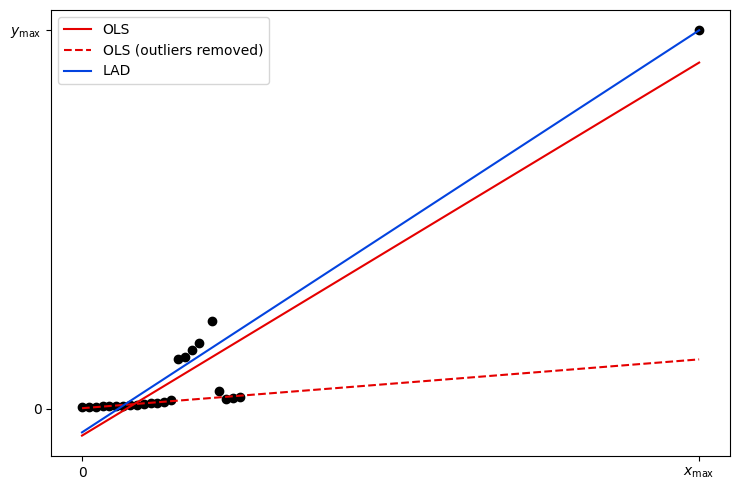

In [6]:
# Modified dataset where LAD also fails.
X_lev = np.copy(X)
y_lev = np.copy(y)
X_lev[-6] *= 5
y_lev[-6] *= 5
X_lev_padded = np.hstack([X_lev, np.ones(X_lev.shape, dtype=X_lev.dtype)])

# Compute OLS solution on modified dataset.
regline_ols_lev, res_ols_lev, rnk_ols_lev, s_ols_lev = lstsq(a=X_lev_padded, b=y_lev)

# Compute LAD solution on modified dataset.
qr_fitted_lev = qr.fit(X_lev, y_lev.reshape(-1))
regline_lad_lev = [qr_fitted_lev.coef_.item(), qr_fitted_lev.intercept_]

# Plot all three solutions.
make_scatter(X=X_lev, y=y_lev,
             lines=[(regline_ols_lev[0], regline_ols_lev[1]),
                    (regline_removed[0], regline_removed[1]),
                    (regline_lad_lev[0], regline_lad_lev[1])],
             colors=["xkcd:red", "xkcd:red", "xkcd:blue"],
             styles=["solid", "dashed", "solid"],
             labels=["OLS", "OLS (outliers removed)", "LAD"])

We have taken the original dataset and modified just one of the original outlying data points, simply multiplying a single data point $(\mathsf{X}_{i},\mathsf{Y}_{i})$ by 5. Considering the first-order optimality conditions for LAD under the linear model, we require

\begin{align}
\sum_{i=1}^{n}\text{sign}(h(\mathsf{X}_{i})-\mathsf{Y}_{i}) \, \mathsf{X}_{i} = 0.
\end{align}

This shows how the value of $\mathsf{Y}_{i}$ can be arbitrarily large without causing problems, whereas an errant value of $\mathsf{X}_{i}$ can be very troublesome. Such data points are said to be "high leverage" in the context of robust linear regression \[RL87\]. We thus see how using LAD instead of OLS does not necessarily realize the desired insensitivity to errant observations, and this should not be surprising, since all OLS and LAD promise is a *small average loss*, nothing more, nothing less.

### A new perspective: seeking a desirable loss distribution

With this context in place, we can get to the central point of this explainer, namely the notion that it might be fruitful to __design learning algorithms based on properties we desire in the loss distribution__. It goes without saying that in an ideal world, we would like all the losses to take on the smallest possible value, both on- and off-sample. Unfortunately, the reality of machine learning in the wild is that we only have limited data and prior knowledge at training time, and thus *"make all losses minimal!"* is a totally unrealistic goal. Not all losses can be made minimal. Tradeoffs are inevitable. In order to responsibly design effective and transparent learning systems, we need the *vocabulary* to make these tradeoffs explicit. By placing our focus on properties of the loss distribution, we have a medium by which we can translate decisions about performance tradeoffs into concrete mathematical notions and executable code.

To motivate this idea further, let us return briefly to the original, unmodified dataset. This is the "nice" setting in which we know that the LAD solution is desirable. We can go one step further and say that the *loss distribution* incurred by the LAD solution is also desirable. Below we plot a histogram of the (training) losses incurred by the two solutions being compared (red is OLS, blue is LAD). Vertical rules denote the average loss (dashed) and median loss (dotted).

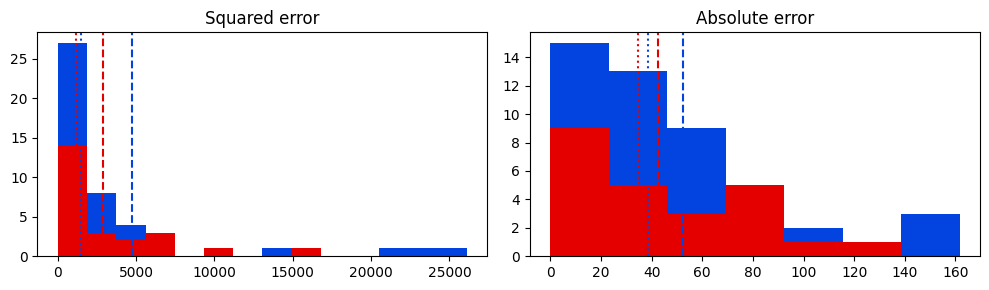

In [7]:
# Compute training losses.
diffs_ols = X.reshape(-1)*regline_ols[0] + regline_ols[1] - y.reshape(-1)
losses_ols_quad = (diffs_ols)**2
losses_ols_abs = np.abs(diffs_ols)
losses_lad_quad = (qr_fitted.predict(X)-y.reshape(-1))**2
losses_lad_abs = np.abs(qr_fitted.predict(X)-y.reshape(-1))

# Plot loss histrograms.
make_hist(losses_quad=[losses_ols_quad, losses_lad_quad],
          losses_abs=[losses_ols_abs, losses_lad_abs],
          colors=["xkcd:red", "xkcd:blue"])

Note that there are some clear differences between the loss distributions of each method. On one hand, the majority of the losses incurred by LAD are smaller than those of OLS, but on the other hand, the LAD solution incurs more extremely large losses. This results in a large gap between the median and mean for LAD. These trends become more visually salient with a larger sample; let us next look at the off-sample losses, corresponding to a fresh sample of the gray points plotted previously in the linear scenario.

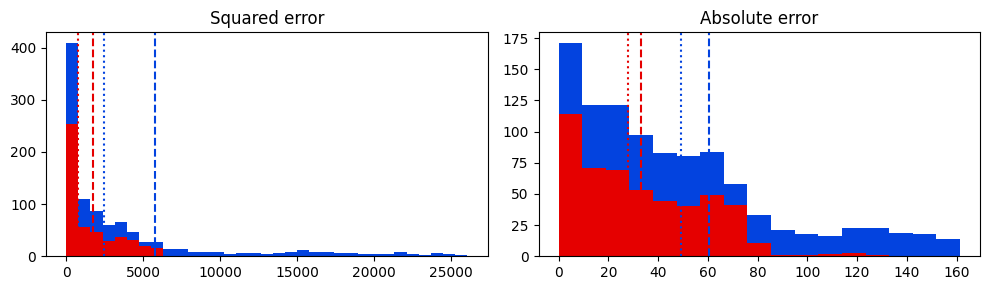

In [8]:
# Compute test losses.
x_offsample, y_offsample_lin = test_data_linear(X=X, y=y, rg=rg)
diffs_ols_te = x_offsample*regline_ols[0] + regline_ols[1] - y_offsample_lin
losses_ols_quad_te = (diffs_ols_te)**2
losses_ols_abs_te = np.abs(diffs_ols_te)
losses_lad_quad_te = (qr_fitted.predict(x_offsample.reshape(len(x_offsample),1))-y_offsample_lin)**2
losses_lad_abs_te = np.abs(qr_fitted.predict(x_offsample.reshape(len(x_offsample),1))-y_offsample_lin)

# Plot loss histrograms.
make_hist(losses_quad=[losses_ols_quad_te, losses_lad_quad_te],
          losses_abs=[losses_ols_abs_te, losses_lad_abs_te],
          colors=["xkcd:red", "xkcd:blue"])

Since the outlying losses can be difficult to see, we also give a zoomed-in view of these histograms.

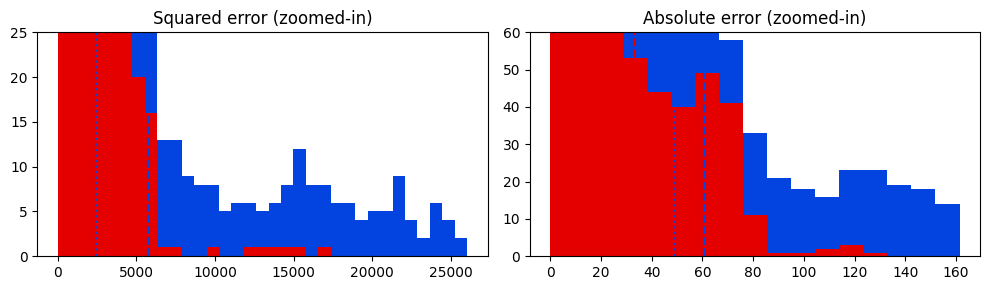

In [9]:
# Plot loss histrograms, zoomed-in.
make_hist(losses_quad=[losses_ols_quad_te, losses_lad_quad_te],
          losses_abs=[losses_ols_abs_te, losses_lad_abs_te],
          tops=[25, 60], colors=["xkcd:red", "xkcd:blue"])

Again we see that regardless of the loss function used to measure prediction error, the majority of the losses are small for LAD, but at the cost of more extremely large errors than OLS. Put very roughly, we'd like a distribution with a very small median, and we are willing to tolerate some heavy tails on the upside (and thus a larger mean). Why focus on these properties? The reason is that these properties transcend this particular dataset. We want a loss distribution with these properties in the original "nice" setting, in the modified setting (with a high-leverage point) where LAD falls apart, and indeed all settings in-between where the majority of data points are representative of the true underlying (here, linear) relationship between inputs and outputs.

The key remaining question: how can we build a learning algorithm that achieves such a distribution? More generally, as our definition of "desirable distribution" changes, what algorithmic modifications are required? Providing some preliminary answers to these questions is the main goal of this explainer, and we will take it at a leisurely pace, step-by-step.

### A concrete alternative

As a first step, and to wrap up this first section, we will consider the most direct approach to the current regression task. Recall the desired properties mentioned earlier:

> Put very roughly, we'd like a distribution with a very small median, and we are willing to tolerate some heavy tails on the upside (and thus a larger mean).

If we want to ensure the median is small, then the most direct method is to use the median loss as an objective function to be passed to an optimization procedure. To make this explicit, let us denote each sample loss by $\mathsf{L}_{i}(h) = \ell(h;\mathsf{X}_{i},\mathsf{Y}_{i})$, and use the notation $\mathsf{L}_{(i)}$ to denote the $i$th largest value, i.e., we have

\begin{align}
\mathsf{L}_{(1)}(h) \leq \mathsf{L}_{(2)}(h) \leq \cdots \leq \mathsf{L}_{(n)}(h).
\end{align}

Note that the ordering of points may naturally change with the choice of $h$. With this notation in place, the program to solve would then be

\begin{align}
\min_{h \in \mathcal{H}} \, \mathsf{L}_{(k)}(h), \, \text{ where } k = \lceil n/2 \rceil.
\end{align}

Statistically speaking, this is a perfectly natural idea, which is of interest regardless of the nature of the model $\mathcal{H}$ or the form of the loss function $\ell(h;x,y)$. On the other hand, from a practical perspective, this idea is extremely naive since actually implementing this minimization is much more difficult than just minimizing the average; even if the loss function is smooth and convex in $h$, these properties need not hold for the median. In the special case where $\mathcal{H}$ is a linear model and $\ell(h;x,y)$ is the squared error, this method was studied almost 40 years ago under the name _least median of squares_ (LMedS), with core ideas dating back much further \[Rou84,RL87\].

A practical implementation of LMedS is available in [the MASS package for R](https://stat.ethz.ch/R-manual/R-patched/library/MASS/html/lqs.html), but in machine learning we typically want flexibility to deal with a wide range of models and loss functions, so for some perspective, let us see how an off-the-shelf solver deals with this task. We use the `minimize` function [built in to SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) using the Nelder-Mead method, initialized by setting $h(x) = ax + b$ with $a$ and $b$ independently and uniformly chosen from the interval $[-5,5]$. We plot the LMedS solution obtained on the original dataset below.

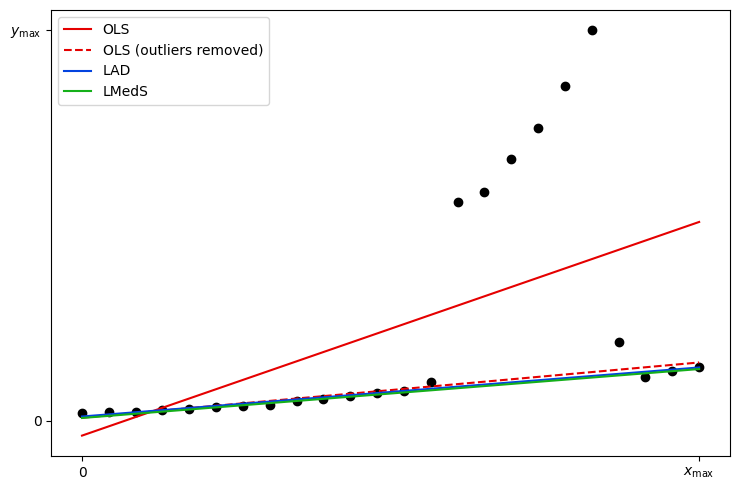

In [10]:
from scipy.optimize import minimize

# Run Nelder-Mead on the least median of squares (LMedS) problem using the original dataset.
lml_result = minimize(
    fun=obj_leastmedloss,
    x0=rg.uniform(low=-5.0, high=5.0, size=2),
    args=(X.reshape(-1), y.reshape(-1), "squared"),
    method="Nelder-Mead"
)
regline_lml = lml_result.x

# Plot the LMedS solution along with the other three candidates considered earlier.
make_scatter(X=X, y=y,
             lines=[(regline_ols[0], regline_ols[1]),
                    (regline_removed[0], regline_removed[1]),
                    (regline_lad[0], regline_lad[1]),
                    (regline_lml[0], regline_lml[1])],
             colors=["xkcd:red", "xkcd:red", "xkcd:blue", "xkcd:green"],
             styles=["solid", "dashed", "solid", "solid"],
             labels=["OLS", "OLS (outliers removed)", "LAD", "LMedS"])

It is evident that the LMedS solution (green) is very similar to the LAD solution (blue) and the solution obtained using manual outlier removal (red, dashed). Both of these alternative solutions achieve a loss distribution with a small median, so this is a natural outcome. The critical remaining question is how well this strategy works on the modified dataset, where the LAD approach is known to fail. We plot the resulting LMS solution below.

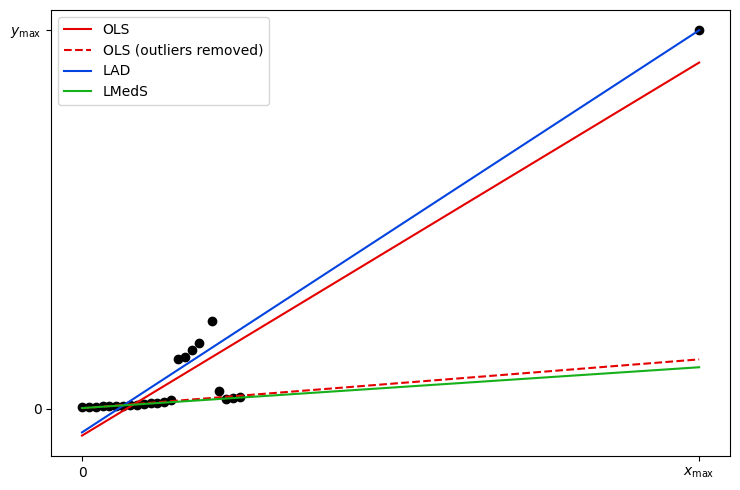

In [11]:
# Once again run LMedS, but this time on the modified high-leverage dataset.
lml_result_lev = minimize(
    fun=obj_leastmedloss,
    x0=rg.uniform(low=-5.0, high=5.0, size=2),
    args=(X_lev.reshape(-1), y_lev.reshape(-1), "squared"),
    method="Nelder-Mead"
)
regline_lml_lev = lml_result_lev.x

# Plot all solutions under the modified dataset.
make_scatter(X=X_lev, y=y_lev,
             lines=[(regline_ols_lev[0], regline_ols_lev[1]),
                    (regline_removed[0], regline_removed[1]),
                    (regline_lad_lev[0], regline_lad_lev[1]),
                    (regline_lml_lev[0], regline_lml_lev[1])],
             colors=["xkcd:red", "xkcd:red", "xkcd:blue", "xkcd:green"],
             styles=["solid", "dashed", "solid", "solid"],
             labels=["OLS", "OLS (outliers removed)", "LAD", "LMedS"])

Fortunately, we see that in this setting as well, the LMedS solution is as we would hope. It is also of some interest that the output is almost identical if we replace the squared error loss $\ell(h;x,y) = (h(x)-y)^{2}$ in the LMedS objective with the absolute error $\ell(h;x,y) = \lvert h(x)-y \rvert$. On the other hand, this procedure does not scale well as the number of parameters grows, and is only meant as a lucid example to illustrate algorithm design principles we are interested in. As a key take-away from this example, we have seen that by *considering the properties that we desire in the loss distribution*, we were able to come up with a simple and transparent learning algorithm that outperforms OLS and LAD, without having to manually remove the outliers or re-design the loss function.

In general, of course, our definition of "desirable loss distribution" may change significantly depending on the problem of interest. In the sections to follow, we will generalize our formulation, and consider a wide range of (quantifiable) properties of the underlying loss distribution.

___

## 2. Quantifying and visualizing learning criteria

Through the warmup example in the previous section, we have established some context for the broader topic of *designing learning algorithms to achieve a desirable loss distribution*. In the previous example, we started with a well-known dataset including outliers, examined the performance of some standard learning algorithms, and based on this performance we decided on the properties of the loss distribution that we would consider "desirable" given the learning task at hand. We then used this as a guide to design an alternative procedure (the median loss minimizer) which, leaving aside issues of scalability, behaved as we would hope and outperformed the more standard procedures. 

In this section, the primary focus is on the means for actually quantifying different properties of the underlying loss distribution. While it was natural for us to use the loss median in the previous example, more generally there will be other properties we would like to emphasize (or ignore), and the goal of this section is to assemble an initial toolkit to quantify such properties.

### Basic formulation
To get started, we introduce some formal notation to faciliate our exposition. In machine learning, much attention is paid to the precise form of the loss function $\ell(h;x,y)$. This was emphasized by the OLS/LAD comparison in the previous section. For our purposes, however, the exact nature of the loss function is not important (yet). Furthermore, there is no need to restrict ourselves to a "supervised learning" task with an input-output pair $(x,y)$, either. Our interest is in the probability distribution of the loss over the random draw of the data that the loss depends on.

Making all this a bit more explicit, let $\mathsf{Z} \sim \mu$ be a random data point with distribution $\mu$, and let us use $\mathsf{L}(h) = \ell(h;\mathsf{Z})$ to denote the random loss of interest, where the loss function $\ell$ can in principle be any real-valued function. To keep ourselves conceptually grounded, we will refer to $\ell(\cdot;\cdot)$ as the __base loss function__ and $\mathsf{L}(h)$ as simply the __base loss__. This general-purpose notation emphasizes the fact that our basic object of interest is the distribution of $\mathsf{L}(h)$.

While the loss distribution is of critical importance, it is quite unwieldy as an indicator of learning algorithm performance. The task of choosing $h$ such that $\mathsf{L}(h)$ is "optimal" is of course an ill-posed problem, since in general, there are countless different ways in which we could measure the optimality of a probability distribution. As such, we must transform the random loss $\mathsf{L}$ into a single real value that can be used to make statements of "optimality" precise and meaningful. As a generic notation, we will denote this transformation by

\begin{align}
\mathsf{L} \mapsto \mathrm{C}(\mathsf{L}) \in \mathbb{R}.
\end{align}

When we want to emphasize the role of $h$, we will overload our notation and write $\mathrm{R}(h)$ instead of $\mathrm{R}(\mathsf{L}(h))$. We will refer to $\mathrm{C}(\mathsf{L})$ as the value of the __learning criterion__ defined by $\mathrm{C}(\cdot)$ that is incurred by $\mathrm{L}$. Without question, the *de facto* standard setting in modern machine learning is to focus on *average* performance, i.e., to quantify optimality as

\begin{align}
\mathrm{C}(h) = \mathbf{E}_{\mu} \mathsf{L}(h).
\end{align}

The expected loss to be incurred by $h$ is a perfectly natural way to define optimal performance. Indeed, both OLS and LAD discussed in the previous example are defined to minimize the (empirical) average loss. However, as the previous example also showed us, there may be clear advantages to considering a different definition of optimality (e.g., the median loss).

Moving forward, we will consider different concrete forms for the criterion $\mathsf{L} \mapsto \mathrm{C}(\mathsf{L})$ to take, and give some empirical examples which highlight the different properties of the loss distribution that can be picked up by different risk function classes. In the end, however, there are always tradeoffs. Recalling our statement from the previous section:

> Unfortunately, the reality of machine learning in the wild is that we only have limited data and prior knowledge at training time, and thus *"make all losses minimal!"* is a totally unrealistic goal. Not all losses can be made minimal. Tradeoffs are inevitable. In order to responsibly design effective and transparent learning systems, we need the *vocabulary* to make these tradeoffs explicit.

Designing a learning criterion forces us to make decisions about what to prioritize, and what to ignore. Let's dive into a concrete example generalizing beyond the expected value of the loss.

### Generalizing the notion of location

Since the expected value of a random value is widely considered to be the canonical location parameter, we shall start by generalizing the notion of the "location" of a probability distribution. As a motivating fact, first recall that if $\mathsf{L}$ has finite variance, the its expected value satisfies

\begin{align}
\mathbf{E}_{\mu}(\mathsf{L}-\mathbf{E}_{\mu}\mathsf{L})^{2} \leq \mathbf{E}_{\mu} (\mathsf{L}-\theta)^{2} < \infty
\end{align}

for any choice of $\theta \in \mathbb{R}$. The mean is the location about which the distribution is most sharply concentrated, in terms of the expected squared deviation. That said, in general, if we change the way in which we measure deviations, the optimal location will change. As such, it is natural to define a general class of location parameters as a solution set

\begin{align}
\mathrm{M}_{\rho}(\mathsf{L}) = \arg\min_{\theta \in \mathbb{R}} \, \mathbf{E}_{\mu} \rho(\mathsf{L}-\theta)
\end{align}

where the function $\rho: \mathbb{R} \to \mathbb{R}_{+}$ is in charge of measuring deviations. The elements of the solution set $\mathrm{M}_{\rho}(\mathsf{L})$ are called *M-parameters* of the distribution of $\mathsf{L}$ \[Kol97\]. In the special case of $\rho(\cdot) = (\cdot)^{2}$ and $\rho(\cdot) = \lvert \cdot \rvert$, we can guarantee that $\mathrm{M}_{\rho}(\mathsf{L})$ includes the mean and median of $\mathsf{L}$ respectively. One can easily design $\rho$ to modulate between these two extremes; as an example from the literature \[Hol21\], let us set

\begin{align}
\rho(x) = \eta \rho_{0}(x/\sigma), \text{ where } \rho_{0}(x) = x\,\mathrm{atan}(x) + \frac{\log(1+x^{2})}{2}
\end{align}

with parameters $\sigma > 0$ and $\eta > 0$ used for re-scaling. The function $\rho_{0}$ used here may appear a bit strange, but it is actually quite simple and useful in that it behaves approximately quadratically around zero, and it is both $\pi/2$-Lipschitz and strictly convex on $\mathbb{R}$. For reference, in the following figure we plot the graphs of $\rho_{0}$ (solid line), and its first two derivatives (dashed, dot-dashed respectively).

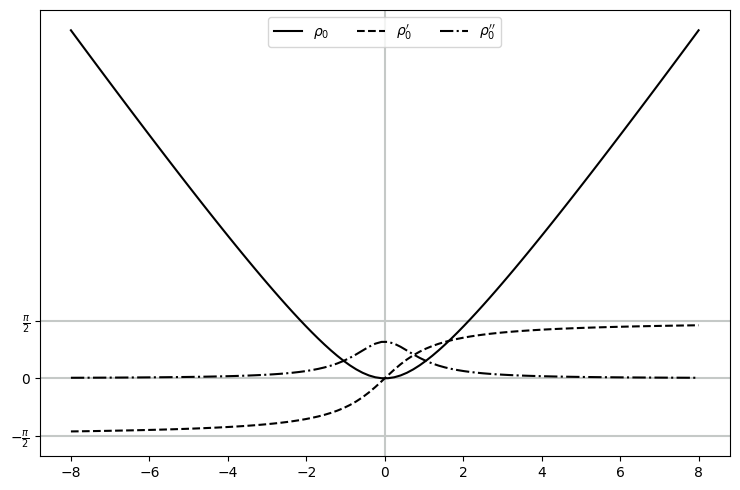

In [1]:
import numpy as np
from setup.utils import make_dispersion_plot, interactive_criterion_plot, interactive_trisk_plot, make_dispersion_comparison, make_dispersion_comparison_colorbars, make_loss_tranforms
%matplotlib inline
seed = 231782381787283786178263
rg = np.random.default_rng(seed=seed)

make_dispersion_plot()

Let us use this class of M-parameters to modulate between the mean and median of a probability distribution. As mentioned in \[Hol21, Rmk. 2\], we have that

\begin{align}
2\sigma^{2}\rho_{0}(x/\sigma) \to x^{2} \text{ as } \sigma \to \infty, \text{ and } 2(\sigma/\pi)\rho_{0}(x/\sigma) \to \lvert x \rvert \text{ as } \sigma \to 0_{+}.
\end{align}

This gives us a precise re-scaling strategy (i.e., precise settings of $\eta$ and $\sigma$) such that the resulting M-parameter approaches the mean as $\sigma$ gets large, and the median as $\sigma$ gets close to zero. For all practical purposes, though, we do not need to be quite so precise. Let us see a numerical example of this in action.

We simulate the distribution of $\mathsf{L}$ using some well-known parametric distributions, and for ease of numerical comparison, we shift the distributions such that $\mathbf{E}_{\mu}\mathsf{L}=0$. We then take a large iid sample from this distribution, and using the `minimize_scalar` function [included in SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html) we seek a minimizer of the map $\theta \mapsto \mathbf{E}_{\mu}\rho(\mathsf{L}-\theta)$, replacing $\mu$ with the empirical distribution.

As a simple first example, we look at the case of a Bernoulli distribution. The most typical situation in which this would arise is when using the zero-one loss function for classification, i.e., $\ell(h;\mathsf{X},\mathsf{Y}) = \mathbf{1}\{h(\mathsf{X}) \neq \mathsf{Y}\}$, which has a Bernoulli distribution with mean parameter equal to $\mathbf{P}\{h(\mathsf{X}) \neq \mathsf{Y}\}$. In the figure below, we look at how, sampling $\mathsf{L}$ from a (centered) Bernoulli distribution, different values of $\sigma$ impact the resulting value of $\mathrm{M}_{\rho}(\mathsf{L})$, and the function value at which $\mathrm{M}_{\rho}(\mathsf{L})$ is optimal.

_Note:_ when running the Jupyter notebook, feel free to play with the parameter slider, here and in other figures, to change the data being generated!

In [2]:
interactive_criterion_plot(
    data="bernoulli", # Bernoulli distribution data (centered)
    rg=rg,
    criteria=["mestToMean", "mestToMed"]
)

Let us unpack the visual elements of the above figure.

- With $\mathbf{E}_{\mu} \rho(\mathsf{L}-\theta)$ viewed as a function of $\theta$, the _solid black line_ denotes the optimal $\theta$ value found by the minimizer (corresponding to $\mathrm{M}_{\rho}(\mathsf{L})$, the "M-location"), for a variety of choices of $\sigma$, recalling that we are using $\rho(x) = \eta \rho_{0}(x/\sigma)$ as described earlier, and that $\eta$ depends on $\sigma$.
- The _dashed black line_ is the value of the objective function achieved at this minimizer; we shade in the difference between these two values to emphasize the degree of dispersion.
- Mean and median values are given by _blue and red horizontal rules_ respectively. The difference between the "mean scale" and "median scale" settings is simply that of re-scaling with $\eta = 2\sigma^{2}$ and $\eta = 2\sigma/\pi$ respectively.
- The _horizontal grey rules_ show the 25th and 75th percentiles (sometimes these overlap with other lines).

Using the same visualization technique, the same trends can of course be observed on continuous distributions as well, as seen in the two examples below.

In [3]:
interactive_criterion_plot(
    data="beta", # Beta distribution data (centered)
    rg=rg,
    criteria=["mestToMean", "mestToMed"]
)

In [4]:
interactive_criterion_plot(
    data="pareto", # Pareto distribution data (centered)
    rg=rg,
    criteria=["mestToMean", "mestToMed"]
)

Note how the mean (blue line) can appear both above and below the median (red line) depending on the direction of the distribution's asymmetric tails. Regardless of direction, the aforementioned $\sigma$-based modulation works as expected.

In the special case where the distribution of $\mathsf{L}$ is symmetric, the M-locations under this symmetric $\rho$ all coincide. Take for example the case of a Normal distribution.

In [5]:
interactive_criterion_plot(
    data="normal", # Normal distribution data (centered)
    rg=rg,
    criteria=["mestToMean", "mestToMed"]
)

In any case, however, this class of M-locations clearly gives us significant flexibility in terms of "sensitivity to tails" when deciding how we want define the location of a loss distribution. Using the strict convexity of the function $\rho_{0}(\cdot)$ just introduced, the solution set $\mathrm{M}_{\rho}(\mathsf{L})$ contains a single element, and it is thus intuitive to design a learning criterion family of the form

\begin{align}
\mathrm{C}_{\textrm{M}}(h) = \mathrm{M}_{\rho}(\mathsf{L}(h)).
\end{align}

Minimizers of the empirical variant of this objective can be shown to enjoy some nice robustness properties \[BJL15\] in principle, but note that from a computational viewpoint, this is a "bi-level program" in that the objective function in $h$ is itself the *solution* of a separate optimization problem (the M-parameter characterization). Solving such problems directly introduces a significant computational overhead, limiting the usefulness of this approach for larger-scale machine learning tasks. Moving forward, we go beyond this class of location parameters and consider some notions of location which are more computationally congenial.

### Flexible worst-case sensitivity

In the previous example, we saw how one can modulate between the median and mean of the underlying loss distribution. In terms of tradeoffs, the closer we are to the median, the more weight we put on ensuring that (given a sample of losses) the _majority_ of losses, albeit not all losses, are small. As a result, less weight is placed on penalizing worst-case rare examples. In contrast to this, most of the best-known learning criteria (often called "risk functions") proposed as alternatives to the expected loss are naturally interpreted as placing more weight on the worst-case than the mean does, with less weight placed on the majority. Here we introduce and examine some well-known examples.

#### Conditional value-at-risk

Perhaps the simplest modification to the mean loss is to consider a _conditional_ expectation, conditioned on some kind of "worst case" event. One of the most natural definitions of such an event is the case in which the loss exceeds a certain threshold, for example, a certain quantile. Making this explicit, let us denote the $\beta$-level quantile of $\mathsf{L}(h)$ for any $0 < \beta < 1$ by

\begin{align}
\mathrm{Q}_{\beta}(h) = \inf\{x \in \mathbb{R}: \mathbf{P}\{\mathsf{L}(h) \leq x\} \geq \beta\}
\end{align}

and then consider the conditional expectation

\begin{align}
\mathrm{CVaR}(h) = \mathbf{E}_{\mu}[\mathsf{L}(h) \,\vert\, \mathsf{L}(h) \geq \mathrm{Q}_{\beta}(h)].
\end{align}

This criterion is well-known as *conditional value-at-risk* (CVaR) \[RU00\].

#### Tilted risk

Instead of conditioning on the event of exceeding a certain quantile, one could of course just target a particular quantile $h \mapsto \mathrm{Q}_{\beta}(h)$ directly. However, as we mentioned in the previous section in the special case of $\beta = 1/2$, quantiles of random losses need not inherent convexity or smoothness properties of the base loss functions underlying them. A smooth approximation of both low- and high-level quantiles can be obtained using

\begin{align}
\mathrm{Tilted}(h) = \frac{1}{\gamma}\log\left(\mathbf{E}_{\mu}\mathrm{e}^{\gamma\mathsf{L}(h)}\right)
\end{align}

and taking the absolute value of parameter $\gamma \neq 0$ sufficiently large. A larger value of $\gamma$ gives a sharper estimate of the extreme quantiles, but the objective function becomes less smooth. This class of criteria has been called *tilted risk* in the machine learning literature \[LBSS21\].

#### Optimized certainty equivalent risk

The two preceding risk classes are closely related to another, much larger class of risk functions. Let $\phi: \mathbb{R} \to \mathbb{R}$ be a monotonic non-decreasing, closed, convex function which satisfies both $\phi(0) = 0$ and $1 \in \partial\phi(0)$ (i.e., the graph of $f(x) = x$ never goes above the graph of $\phi(x)$). It is non-positive on the negative half-line, positive on the positive half-line, and must either be differentiable at 0 with a slope of 1, or include the slope of 1 in its sub-differential. Given such a function $\phi$, the *optimized certainty equivalent (OCE)* risk is defined by

\begin{align}
\mathrm{OCE}_{\phi}(h) = \inf_{\theta \in \mathbb{R}} \, \left[ \theta + \mathbf{E}_{\mu}\phi(\mathsf{L}(h)-\theta) \right].
\end{align}

The class of OCE risks includes many special cases \[LPS20\]. Trivially we obtain the expected loss by setting $\phi(x) = x$. We can obtain any $\beta$-level CVaR introduced earlier by setting $\phi(x) = \max\{0,x\}/(1-\beta)$, and can recover the special case of tilted risk with $\gamma > 0$ by setting $\phi(x) = (\mathrm{e}^{\gamma x}-1)/\gamma$. Note that if we define $\varphi(x) = \phi(x) - x$, we can trivially re-write any OCE risk as

\begin{align}
\mathrm{OCE}_{\phi}(h) = \mathbf{E}_{\mu}\mathsf{L}(h) + \inf_{\theta \in \mathbb{R}} \, \mathbf{E}_{\mu}\varphi(\mathsf{L}(h)-\theta),
\end{align}

and since by the assumptions made on $\phi$ we have $\varphi(x) \geq 0$, it is evident that all OCE risks are at least as sensitive to extreme events as the mean is. This expression also allows for the interpretation of OCE risks as being a sum of "location" and "deviation" parameters of the underlying distribution; we will return to this notion shortly. Since $\phi(\cdot)$ is assumed to be convex _and_ monotonic, whenever the base loss function is convex in $h$, this property is carried over over to the OCE risk. Furthermore, unlike the M-locations, the risk is characterized as the minimum value (rather than the minimizer itself), meaning that it is quite straightforward to optimize jointly in $(h,\theta) \in \mathcal{H} \times \mathbb{R}$.

#### Distributionally robust optimization risk

Another important set of risk functions considers a "robust regularization" of the expected loss, by accounting for potential shift in the underlying data distribution. Written succinctly, instead of just paying attention to a single loss $\mathsf{L}(h) = \ell(h;\mathsf{Z})$ with $\mathsf{Z} \sim \mu$, one considers the worst case out of a family of random losses $\mathcal{L}$, i.e., a criterion of the general form

\begin{align}
\mathrm{DRO}(h) = \sup\left\{\mathbf{E}[\mathsf{L}(h)] : \mathsf{L} \in \mathcal{L}\right\}.
\end{align}

The exact nature of this criterion of course depends entirely on how the set $\mathcal{L}$ is defined. A typical example is a ball of radius $a \geq 0$ set around the initial data distribution $\mu$, i.e., essentially we have $\mathcal{L} = \{\ell(\cdot;Z): Z \sim \nu, \lVert \nu - \mu \rVert \leq a\}$, where the norm condition $\lVert \nu - \mu \rVert \leq a$ is often weakened to be measured with some divergence function (not necessarily a proper metric). One of the most well-studied examples is an $a$-radius ball measured using the $\chi^{2}$-divergence \[ZDKR21\], which yields a criterion with a form quite reminiscent of the OCE risks we saw earlier:

\begin{align}
\mathrm{DRO}_{\chi^{2}}(h) = \inf_{\theta \in \mathbb{R}} \, \left[ \theta + \sqrt{(1+2a)\mathbf{E}_{\mu}(\mathsf{L}(h)-\theta)_{+}^{2}} \right]
\end{align}

for $a > 0$, noting that $(\cdot)_{+} = \max\{\cdot,0\}$. Minimizing criteria of this form encourages a certain degree of robustness to changes in the underlying distribution, and this quantity is usually called the *$\chi^{2}$-DRO risk*, where DRO stands for *distributionally robust optimization*. While strictly speaking this is not an OCE risk, it is quite similar in that it is always at least as sensitive to extreme values as the mean is, though that sensitivity is defined in a different way. It also shares the convenient property that the convexity of the loss function is carried over to the $\chi^{2}$-DRO risk, and solving for $(h,\theta)$ together is practical.

#### A numerical comparison

As we did earlier with the M-location example, let us visualize the learning criterion classes described above on some simulated data. Since we want to visualize *classes* and not individual criteria, we consider the criterion values returned by CVaR over a range of $\beta$ choices, tilted risk over a range of $\gamma$ choices, and $\chi^{2}$-DRO risk over a range of $a$ choices. The following figure is analogous to that obtained for the M-locations earlier.

In [6]:
interactive_criterion_plot(
    data="bernoulli", # Bernoulli distribution data (centered)
    rg=rg,
    criteria=["cvar", "entropic", "dro"]
)

Some attention is required when parsing this figure. First of all, as with the M-location case, criterion computations are done by minimizing an objective over $\theta \in \mathbb{R}$; the optimal value of $\theta$ found is denoted by a solid black line, and the objective function value is denoted by a dashed black line. This is identical to the M-location case, but note that the criteria are defined in terms of the objective function value, rather than the optimal $\theta$. This point is different from the M-location example. As such, criterion values are denoted by dashed black lines here. Everything else is the same. Another point is regarding the tilted risk. For $\gamma > 0$ it is an OCE risk, and some basic calculus shows us that the optimal $\theta$ is in fact equal to the minimal objective function value. For $\gamma < 0$, it is not an OCE risk, but it can still be computed analytically, which we have done. As such, there is only one line for the tilted risk in all cases. Finally, the horizontal axis for $\chi^{2}$-DRO risk is $\widetilde{a}$, not $a$. We have used the common re-parametrization of $a = ((1-\widetilde{a})^{-1}-1)^{2}/2$ for numerical convenience.

For reference, results for the other data distributions seen earlier are given below.

In [7]:
interactive_criterion_plot(
    data="beta", # Beta distribution data (centered)
    rg=rg,
    criteria=["cvar", "entropic", "dro"]
)

In [8]:
interactive_criterion_plot(
    data="pareto", # Pareto distribution data (centered)
    rg=rg,
    criteria=["cvar", "entropic", "dro"]
)

In [9]:
interactive_criterion_plot(
    data="normal", # Normal distribution data (centered)
    rg=rg,
    criteria=["cvar", "entropic", "dro"]
)

Note that in all cases, as the worst-case sensitivity is reduced ($\beta \to 0$, $\gamma \to 0$, $a \to 0$), the criterion value (dashed black line) returned by each class approachs the mean, as we would anticipate. As the sensitivity levels are raised, it is apparent that these classes tend to be much more sensitive to tails on the upside than the M-locations we looked at earlier, and indeed, the notion of "location" can shift quite far from the mean and median. Closely related to this point, note that regardless of the symmetry of the data, these criteria can be readily taken towards extreme values *larger* than the mean, but not on the other direction (except for tilted risk with $\gamma < 0$, for which one can only go below the mean).

### Additional flexibility based on dispersion

Let us briefly recapitulate the main points we have covered thus far. M-locations can be used as a flexible representation of distribution location (e.g., modulating between the mean and median), but computational issues mean that they cannot be a workhorse of large-scale machine learning, but rather just play a supporting role. OCE risks and DRO risks are much more computationally convenient, but their expressive power is limited in that all they are designed to do is add a worst-case penalty to the expected loss. In addition, they tend to be highly _asymmetric_ in that this "worst-case penalty" only effectively measures deviations in the upward direction (i.e., extremely large losses beyond a certain threshold). To see this, first recall that we were able to write any OCE risk as

\begin{align}
\mathrm{OCE}_{\phi}(h) = \mathbf{E}_{\mu}\mathsf{L}(h) + \inf_{\theta \in \mathbb{R}} \, \mathbf{E}_{\mu}\varphi(\mathsf{L}(h)-\theta)
\end{align}

where $\varphi(x) = \phi(x) - x$ is essentially tasked with measuring deviations that will be used as an extra penalty on top of the mean. Since the OCE class demands that $\phi(\cdot)$ grow slowly (or not at all) on the negative half-line, the resulting deviations measured by $\varphi(\cdot)$ tend to be skewed toward the upside (i.e., losses much larger than the threshold $\theta$), and are insensitive to deviations on the downside (e.g., in the case of losses that are unbounded below, negative rewards, etc.). Plus, the "location" one can capture is always as least as large as the mean. As a systematic and flexible way to address these issues and completement the existing risk classes, a recent line of work \[Hol22\] has considered replacing the OCE-style $\phi(\cdot)$ with a function $\rho_{\alpha}(\cdot)$ from the following class:

\begin{align}
\rho_{\alpha}(x) = 
\begin{cases}
x^{2}/2, & \text{if } \alpha = 2\\
\log\left(1 + x^{2}/2\right), & \text{if } \alpha = 0\\
1 - \exp\left(-x^{2}/2\right), & \text{if } \alpha = -\infty\\
\frac{\lvert \alpha-2 \rvert}{\alpha}\left(\left(1 + \frac{x^{2}}{\lvert \alpha-2 \rvert}\right)^{\alpha/2} - 1\right), & \text{otherwise}.
\end{cases}
\end{align}

For ease of reference we call this the "Barron class" of functions for measuring deviations, since it was used by J.T. Barron with great effect in computer vision applications for _loss function_ design (quite different from our usage here) \[Bar19\]. While the definition looks complicated, the basic traits can be summarized succinctly as follows.

- Regardless of the parameter $\alpha$, the function $\rho_{\alpha}$ is essentially quadratic around zero.
- At the extreme end of $\alpha = 2$, $\rho_{\alpha}$ is a quadratic function.
- For $\alpha \geq 1$, $\rho_{\alpha}$ is convex. Moving from $\alpha = 2$ to $\alpha = 1$, the growth slows from quadratic to linear.
- For $\alpha < 1$, inflection points appear and the function becomes concave far from zero.
- Moving from $\alpha = 1$ to $\alpha = 0$, the growth slows from linear to logarithmic.
- For $\alpha < 0$, the function is bounded.

It is instructive to visually compare these classes of deviation functions.

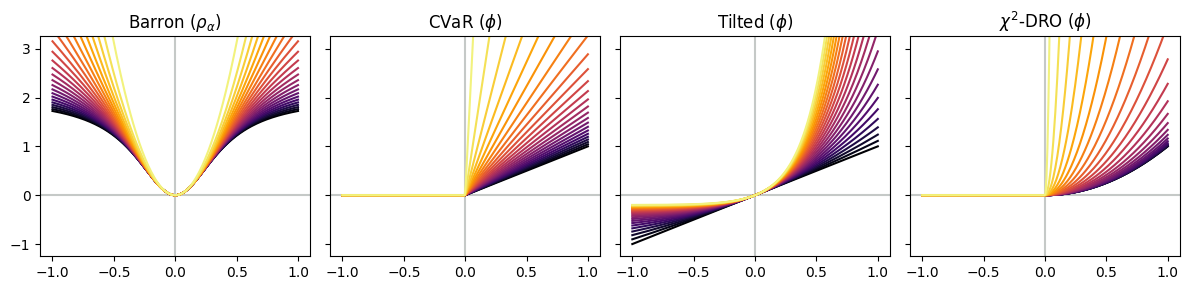

In [10]:
make_dispersion_comparison()

Colors correspond to the parameters underlying each class of criteria, namely $\alpha$ for the Barron class, $\beta$ for CVaR, $\gamma$ for the tilted risk, and $\widetilde{a}$ for $\chi^{2}$-DRO. For reference, color bars are given below.

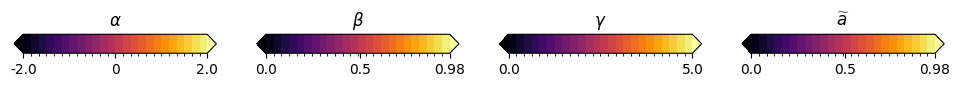

In [11]:
make_dispersion_comparison_colorbars()

Starting from the left-most figure, we have the graph of $x \mapsto \rho_{\alpha}(x/\sigma)$ plotted for numerous values of $\alpha$, with $\sigma = 0.2$ for ease of visual comparison with other functions. Next we have the graphs of $\phi(x)$ for both CVaR and tilted risk over different choices of $\beta$ and $\gamma$. Finally, for $\chi^{2}$-DRO risk we have plotted the analogous function $\phi(x) = (1+2a)(x)_{+}^{2}$, where $a$ is re-parametrized using $\widetilde{a}$ as before. The asymmetry and fast growth of the OCE and $\chi^{2}$-DRO risks is obvious, and is in stark contrast with both the symmetry and potentially sub-linear growth of the Barron class.

With the basic features of this function $\rho_{\alpha}$ understood, the general-purpose criterion class studied in \[Hol22\] is defined as

\begin{align}
\mathrm{R}_{\textup{T}}(h;\theta) = \eta\theta + \mathbf{E}_{\mu}\rho_{\alpha}\left(\frac{\mathsf{L}(h)-\theta}{\sigma}\right).
\end{align}

This is called the threshold risk (or T-risk), where $\theta$ is the "threshold" about which the function $\rho_{\alpha}$ is used to measure dispersion, after re-scaling with $\sigma$. Note that the threshold is left free, but as a natural special case, the minimal T-risk

\begin{align}
\underline{\mathrm{R}}_{\textup{T}}(h) = \inf_{\theta \in \mathbb{R}} \mathrm{R}_{\textup{T}}(h;\theta)
\end{align}

gives us a risk function whose form looks very similar to the OCE and $\chi^{2}$-DRO risks. Like these risks, the "location" captured by each risk is determined implicitly via the function measuring deviations, but in a bi-directional manner, and with more control over tail sensitivity than we get from just using the sum of mean and variance. On the computational side, much like OCE and DRO risks, we can solve for $(h,\theta)$ jointly in a straightforward way. The only caveat is that since $\rho_{\alpha}$ is not monotonic, even if the base loss function is convex, the map $h \mapsto \mathrm{R}_{\textup{T}}(h;\theta)$ need not be convex.

Let us proceed by once again visualizing a subset of the T-risk class. For ease of comparison with the other risk classes, we will consider the "minimal" T-risk $\underline{\mathrm{R}}_{\textup{T}}(h) = \inf_{\theta} \mathrm{R}_{\textup{T}}(h;\theta)$. This means we can only take $\alpha \geq 1$ (otherwise $\underline{\mathrm{R}}_{\textup{T}}(h) = -\infty$). Since there are three influential parameters here ($\alpha$, $\sigma$, and $\eta$), we will have to take up each of them separately (with the others fixed). The following figure is analogous to the previous risk class visualizations done in this section.

In [12]:
interactive_trisk_plot(
    data="bernoulli", # Bernoulli distribution data (centered)
    rg=rg
)

Adjusting the $\alpha$ value has an effect similar to that seen in the M-location example much earlier. On the other hand, $\sigma$ and $\eta$ have a very different and quite pronounced effect. When $\eta \to 0$, the minimal T-risk value is precisely the generalized deviation incurred at the M-location induced by $\rho_{\alpha}$. When $\eta$ is negative, it shifts the optimal treshold upward, and when $\eta$ is positive, it pushes the optimal threshold downward. The scaling parameter $\sigma$ essentially controls the scale at which deviations are processed in a quadratic fashion versus a (potentially) linear fashion. For reference, let us visualize the minimal T-risk under the other three distributions examined previously.

In [13]:
interactive_trisk_plot(
    data="beta", # Beta distribution data (centered)
    rg=rg
)

In [14]:
interactive_trisk_plot(
    data="pareto", # Pareto distribution data (centered)
    rg=rg
)

In [15]:
interactive_trisk_plot(
    data="normal", # Normal distribution data (centered)
    rg=rg
)

A more detailed study of the key traits of the T-risk class is in the previously cited paper \[Hol22\]. Now that we have seen how a variety of learning criterion families behave under different loss distributions, to wrap up this section we will consider how losses are transformed in the process of computing the aforementioned criteria.

### Loss transformations

Put roughly, the ultimate objective of machine learning is "good performance at test time given limited information at training time," and in this section we have been using the notion of a risk function $\mathsf{L} \mapsto \mathrm{C}(\mathsf{L})$ to make the notion of "good performance" concrete and explicit. Designing a learning criterion is great, but in the end, what we want is a learning algorithm that realizes a good enough criterion value with sufficiently high probability over the random draw of training data. How do we link up criterion design to learning procedures?

If we take $\mathsf{L}$ to be a test loss, the risk value $\mathrm{C}(\mathsf{L})$ is an ideal quantity, depending on knowledge of the true distribution of $\mathsf{L}$, which we of course do not have at training time. This means that if we want to find some $h \in \mathcal{H}$ such that $\mathrm{C}(h)$ is small (assuming smaller is better), we will need come up with some data-driven estimates of $\mathrm{C}(\cdot)$ or some properties of $\mathrm{C}(\cdot)$ (e.g., gradients, etc.). Assuming still that $\mathsf{L}(h) = \ell(h;\mathsf{Z})$ for an arbitrary base loss function and $\mathsf{Z} \sim \mu$, the next best thing to knowing $\mu$ is having an iid sample $\mathsf{Z}_{1},\ldots,\mathsf{Z}_{n}$ from $\mu$ available at training time. Arguably the simplest algorithmic strategy is as follows: *replace $\mu$ with the empirical distribution, and use the resulting empirical criterion as an objective function.* Let us see where this simple strategy leads us.

In the traditional setting of $\mathrm{C}(h) = \mathbf{E}_{\mu}\mathsf{L}(h)$, the resulting empirical objective is of course

\begin{align}
h \mapsto \frac{1}{n}\sum_{i=1}^{n}\mathrm{L}_{i}(h)
\end{align}

where we have denoted the sample losses by $\mathsf{L}_{i}(h) = \ell(h;\mathsf{Z}_{i})$. It goes without saying that this is empirical risk minimization (ERM), the central paradigm of traditional statistical learning theory. Similarly, for the OCE risk we have

\begin{align}
(h,\theta) \mapsto \theta + \frac{1}{n}\sum_{i=1}^{n}\phi(\mathsf{L}_{i}(h)-\theta).
\end{align}

For the $\chi^{2}$-DRO risk we have

\begin{align}
(h,\theta) \mapsto \theta + \sqrt{(1+2a)\frac{1}{n}\sum_{i=1}^{n}(\mathsf{L}_{i}(h)-\theta)_{+}^{2}},
\end{align}

and for the T-risk we have

\begin{align}
(h,\theta) \mapsto \eta\theta + \frac{1}{n}\sum_{i=1}^{n}\rho_{\alpha}\left(\frac{\mathsf{L}_{i}(h)-\theta}{\sigma}\right).
\end{align}

Note that inherent in each of these estimators is a *transformation of the base loss function*. These transformations are as follows:

- ERM: $h \mapsto \ell(h;\mathsf{Z}_{i})$ (trivial, no change)
- OCE: $h \mapsto \phi(\ell(h;\mathsf{Z}_{i})-\theta)$
- $\chi^{2}$-DRO: $h \mapsto (1+2a)(\ell(h;\mathsf{Z}_{i})-\theta)_{+}^{2}$
- T-risk: $h \mapsto \rho_{\alpha}(\ell(h;\mathsf{Z}_{i})-\theta)$

One thus might be tempted to say that the design of new risk functions is just the design of new loss functions, and that we are still just doing ERM. Of course one can take this viewpoint, but methodologically it seems wiser to separate *loss function design* and *learning criteria design* into two distinct elements of the machine learning workflow. The most obvious reason is that loss functions are very tightly interwoven with each specific learning task, since they are where data meet the model. On the other hand, motivations for a choice of criterion may be entirely distinct from the value judgements to be encoded in a loss function. In particular, practitioners in computer vision and natural language processing fields have come up with all sorts of interesting and effective task-specific loss functions. On the other hand, the notion of "achieving a desirable loss distribution" is what motivates learning criterion design, and can be applied regardless of how the losses are computed.

To close this section, let us consider how the preceding "loss transformations" actually look when we plug in some typical concrete forms for $\ell(\cdot;\cdot)$. To start, let us assume the simplest possible case, where $h$ is not a function, but just a real value $h \in \mathbb{R}$ we need to select, and let us start with a simple squared error function, i.e., $\ell(h) = (h-h^{\ast})^{2}$, where $h^{\ast}$ is some pre-fixed unknown ideal setting. We compute the transformed losses mentioned above for the T-risk, CVaR, tilted, and $\chi^{2}$-DRO risk classes below, with $h^{\ast} = \pi$.

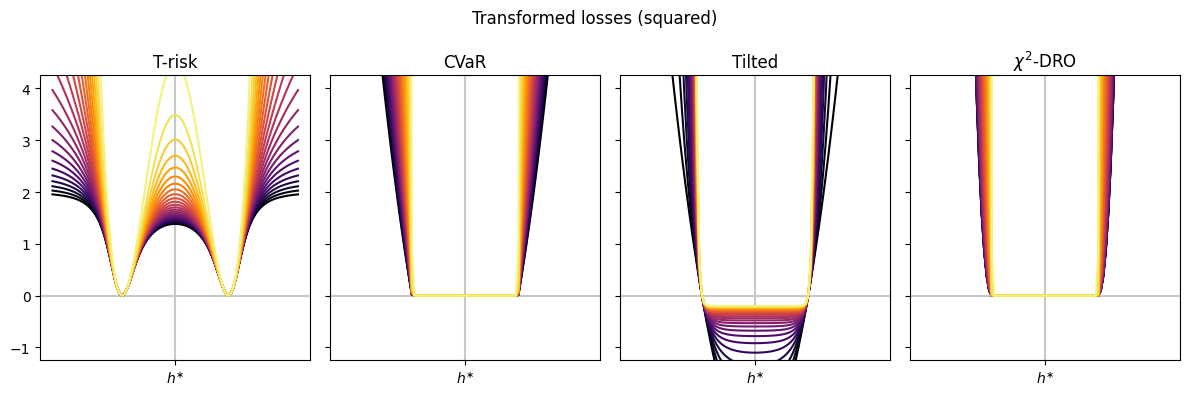

In [16]:
make_loss_tranforms(loss_names=["squared"])

The different colours used in each plot (reading left to right) correspond to different choices of $\alpha$, $\beta$, $\gamma$, and $\widetilde{a}$ respectively, taken over the same ranges as shown in the previous colourbars (noting however that there is no re-scaling with $\sigma$ here for T-risk). While it is obvious that the T-risk does not preserve convexity, for large enough values of $\alpha$, there is a form of weak convexity \[Hol22\]. Let us do a similar visualization for three other concrete loss functions, namely the absolute error $\ell(h) = \lvert h-h^{\ast} \rvert$, the hinge loss $\ell(h) = \max\{1-hh^{\ast},0\}$, and the cross-entropy loss $\ell(h) = \log(1+\exp(-hh^{\ast}))$.

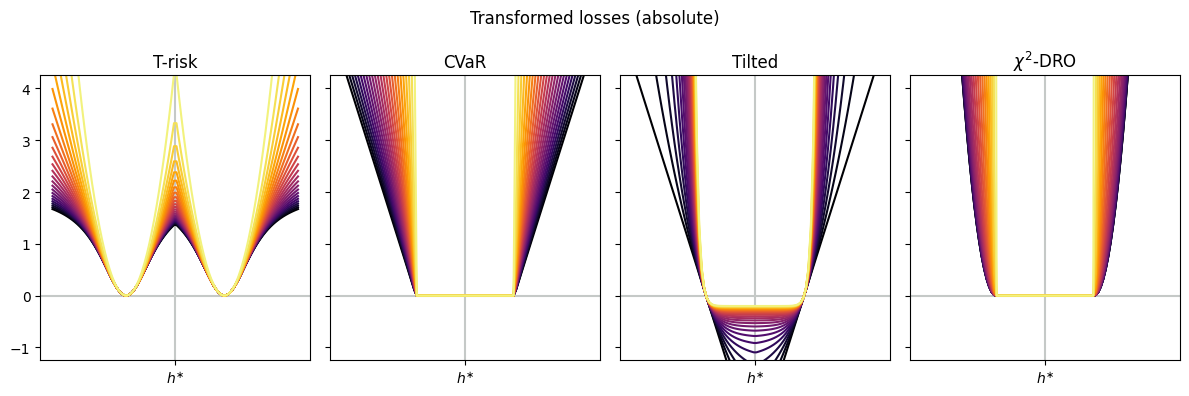

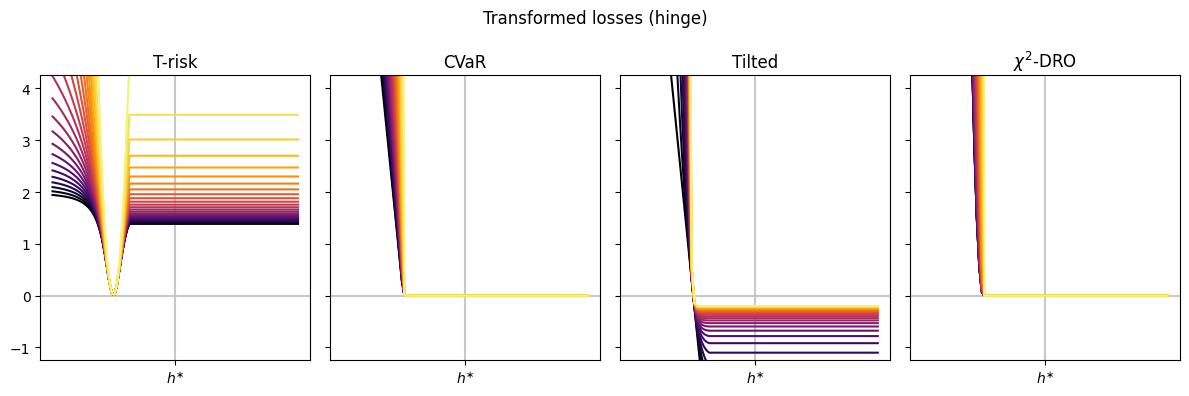

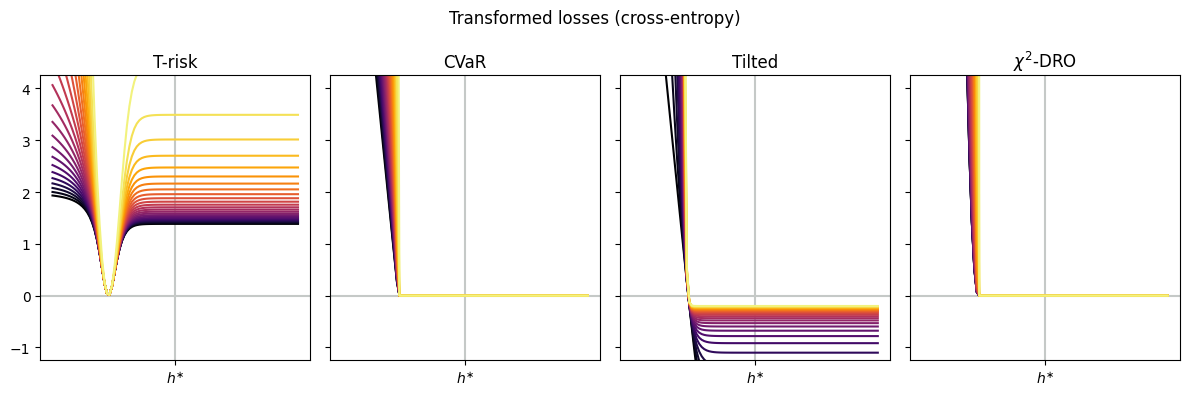

In [17]:
make_loss_tranforms(loss_names=["absolute", "hinge", "cross-entropy"])

Once again, we see how both the shape of the base loss function and the nature of the transformation are reflected quite clearly even in these simple examples, shedding some light into how "criterion design" and "loss design" can interact. Moving forward, in the next section we will use some simple examples to highlight the limitations of typical criterion classes.

___

## 3. Fundamental limitations

For the final section of this explainer, we look at some pitfalls to watch out for, both when designing novel learning criteria and when choosing from existing criteria.

Let us start with the "easy" setting. If we have some criterion $\mathsf{L} \mapsto \mathrm{C}(\mathsf{L})$ to be optimized, and our definition of "good performance" is *completely* characterized by "$\mathrm{C}(\mathsf{L}(h))$ is sufficiently small", then things are simple. All we need to do is (as discussed earlier) find some way to estimate $\mathrm{C}(\mathsf{L}(h))$ based on training samples and seek to optimize that with respect to $h$. This setting is easy because we have *committed* to the criterion $\mathrm{C}$, in the sense that if we are able to find a $h$ such that the test loss $\mathrm{L}(h)$ has a small value under $\mathrm{C}$, then we will not complain.

Unfortunately, the real world (and human nature) is typically not quite so simple. While we may commit to using $\mathrm{C}$ to guide the learning algorithm, there may be other performance metrics that we are interested in. This is typically unavoidable, since the abstract notion of "performance" in machine learnining is multi-faceted, and different stakeholders may have different concrete objectives. Many criteria are very easy to compute, but difficult to optimize at training time; there is often a gap between the criteria that we directly aim for during training, and the criteria that we would ideally like to aim for. It is this gap that leads to some subtle challenges and pitfalls in criterion selection and design. In the following sub-sections, we will consider two illustrative examples.

### One-sided criteria and monotonicity

As a concrete example, our starting point is the variance-regularized expected loss, defined by

\begin{align}
\mathrm{R}_{\lambda}(\mathsf{L}) = \mathbf{E}[\mathsf{L}] + \lambda \mathbf{V}[\mathsf{L}]
\end{align}

where $\lambda \geq 0$ controls the amount of weight put on the loss variance $\mathbf{V}[\mathsf{L}]$. This criterion, and other related criteria, are ubiquitous in the context of decision making under uncertainty, going back to classic work on portfolio optimization by Markowitz. Keeping our focus on machine learning, if we ignore computational issues, then we could just use the empirical analogue of $\mathrm{R}_{\lambda}$ and run empirical risk minimization. This is the "sample variance penalization" (SVP) algorithm studied by Maurer and Pontil \[MP09\]. In practice, however, *convex* alternatives to $\mathrm{R}_{\lambda}$ are often preferred. Links between mean-variance $\mathrm{R}_{\lambda}$ and criteria such as DRO and OCE are now well-established in the literature \[DN19, GKL18, LPS20\], and these criteria are frequently used in practice.

The question of interest here: how well-aligned these objective functions are with the ultimate objective $\mathrm{R}_{\lambda}$? Let $\mathrm{C}$ be some criterion of interest defined on a set $\mathcal{L}$ of random losses, and consider the following conditions.

- "Risk aversity": $\mathrm{C}(\mathsf{L}) \geq \mathbf{E}[\mathsf{L}]$ holds for all $\mathsf{L} \in \mathcal{L}$.
- "Weak monotonicity": $\mathbf{P}\{ \mathsf{L}_{1} \leq \mathbf{E}[\mathsf{L}_{2}]\} = 1$ implies $\mathrm{C}(\mathsf{L}_{1}) \leq \mathbf{E}[\mathsf{L}_{2}]$ for any $\mathsf{L}_{1}, \mathsf{L}_{2} \in \mathcal{L}$.

For example, $\chi^{2}$-DRO and OCE risks all satisfy the above conditions. Consider the following simple pair of bounded loss distributions.

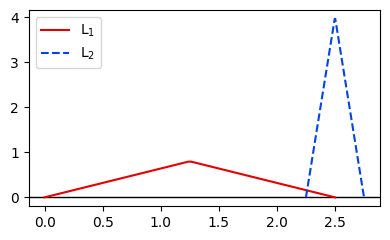

In [1]:
from setup.utils import make_beta, make_weibull, make_triangles, make_nocollapse

make_triangles()

Note that the above pair of loss distributions satisfies $\mathsf{L}_{1} \leq \mathbf{E}[\mathsf{L}_{2}]$ with probability 1, and $\mathbf{V}[\mathsf{L}_{1}] > \mathbf{V}[\mathsf{L}_{2}]$ also holds. Another example is given below.

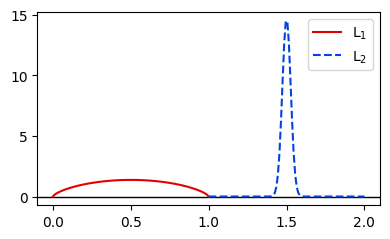

In [2]:
make_beta()

Once again, we have $\mathsf{L}_{1} \leq \mathbf{E}[\mathsf{L}_{2}]$ (in fact $\mathsf{L}_{1} \leq \mathsf{L}_{2}$) with probability 1, and $\mathbf{V}[\mathsf{L}_{1}] > \mathbf{V}[\mathsf{L}_{2}]$. By assumptions on $\mathrm{C}$, in both these cases, we clearly have $\mathrm{C}(\mathsf{L}_{1}) \leq \mathrm{C}(\mathsf{L}_{2})$. On the other hand, it turns out (it can be proven) that for *any* such pair of loss distributions, whenever $\lambda$ is taken large enough, namely such that

\begin{align*}
\lambda > \frac{\mathbf{E}[\mathsf{L}_{2}] - \mathbf{E}[\mathsf{L}_{1}]}{\mathbf{V}[\mathsf{L}_{1}] - \mathbf{V}[\mathsf{L}_{2}]}
\end{align*}

holds, then the mean-variance values will satisfy $\mathrm{R}_{\lambda}(\mathsf{L}_{1}) > \mathrm{R}_{\lambda}(\mathsf{L}_{2})$. When we put enough weight on the variance, it is *impossible* for $\chi^{2}$-DRO or OCE to agree with $\mathrm{R}_{\lambda}$, meaning optimality in these convex criteria implies sub-optimality in the original ultimate criterion of interest. This is one natural "pitfall" of using one-sided criteria. It should be noted that two-sided criteria (such as T-risk and related quantities) do not suffer from this limitation, but of course they have their own tradeoffs.

One key difference between "one-sided" and "two-sided" criteria is how deviations about some location of interest are measured. One-sided criteria are defined using *monotonic* functions (e.g., $\phi$ for OCE and $(\cdot)_{+}$ for $\chi^{2}$-DRO), while two-sided criteria use non-monotonic functions (e.g., $\rho_{\alpha}$ seen earlier). Note that we also saw the notion of "weak monotonicity" pop up earlier, where as saw that all (weakly) monotonic and risk-averse criteria cannot in general align with $\mathrm{R}_{\lambda}$. Without veering too far off track, the broad notion of monotonicity in learning criteria is interesting, but can be complicated. The *usual* definition of criterion monotonicity (for $\mathrm{C}$ on $\mathcal{L}$) is as follows: monotonicity means that the implication

\begin{align*}
\mathbf{P}\{\mathsf{L}_{1} \leq \mathsf{L}_{2}\} = 1 \implies \mathrm{C}(\mathsf{L}_{1}) \leq \mathrm{C}(\mathsf{L}_{2})
\end{align*}

holds for any $\mathsf{L}_{1}, \mathsf{L}_{2} \in \mathcal{L}$. With the mean-variance criterion $\mathrm{R}_{\lambda}$ as context, it is natural to consider other notions of monotonicity. For example, something that might be called "mean-variance monotonicity" (henceforth, MV-monotonicity), and defined analogously by the implication

\begin{align*}
\mathbf{E}[\mathsf{L}_{1}] \leq \mathbf{E}[\mathsf{L}_{2}] \text{ and } \mathbf{V}[\mathsf{L}_{1}] \leq \mathbf{V}[\mathsf{L}_{2}] \implies \mathrm{C}(\mathsf{L}_{1}) \leq \mathrm{C}(\mathsf{L}_{2}).
\end{align*}

This notion is distinct from monotonicity, in that neither property can in general be seen as "stronger" and implying the other, without additional assumptions on $\mathcal{L}$. For example, for each of the following statements, there exists a criterion $\mathrm{C}$ and set of random losses $\mathcal{L}$ such that they hold.

- $\mathrm{C}(\cdot)$ is MV-monotonic but fails to be monotonic.
- $\mathrm{C}(\cdot)$ is monotonic but fails to be MV-monotonic.
- $\mathrm{C}(\cdot)$ is both monotonic and MV-monotonic.
- $\mathrm{C}(\cdot)$ is neither monotonic nor MV-monotonic.
- Both monotonicity and MV-monotonicity can be rendered null in the sense of there being no pair $(\mathsf{L}_{1},\mathsf{L}_{2})$ from $\mathcal{L}$ such that the left-hand side of the implication holds.

The validity of these statements can be readily confirmed with simple constructions. Consider the following pair of distributions.

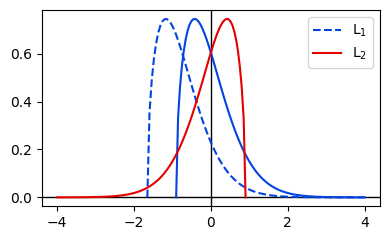

In [3]:
make_weibull()

Using symmetry, the blue distribution (solid line) has the same mean and variance as the red distribution denoted $\mathsf{L}_{2}$. Shifting the blue distribution to the left yields the dashed blue distribution, denoted $\mathsf{L}_{1}$. Note that $\mathbf{V}[\mathsf{L}_{1}] = \mathbf{V}[\mathsf{L}_{2}]$, and $\mathbf{E}[\mathsf{L}_{1}] < \mathbf{E}[\mathsf{L}_{2}]$, so any MV-monotonic criterion cannot prefer $\mathsf{L}_{2}$ over $\mathsf{L}_{1}$, but this is precisely what happens under some monotonic criteria such as quantiles. Low-level quantiles prefer the $\mathsf{L}_{2}$ due to its long left tail, and high-level quantiles prefer $\mathsf{L}_{2}$ since it is bounded above, unlike $\mathsf{L}_{1}$; setting $\mathrm{C}(\mathsf{L}) = \mathrm{Q}_{\beta}(\mathsf{L})$ with $\beta$ sufficiently close to 0 or 1 will result in $\mathrm{C}(\mathsf{L}_{2}) < \mathrm{C}(\mathsf{L}_{1})$.

### Unintentional criterion collapse

Another potential pitfall related to criterion design is that of "criterion collapse", a term that has appeared in the machine learning literature only recently \[Hol24\]. Put simply, given some set of candidates $\mathcal{H}$, let $\mathcal{H}_{\mathcal{E}}^{\ast}$ denote the subset of $\mathcal{H}$ which minimizes the expected 0-1 loss, i.e., the set of minimizers of the *error probability* $\mathcal{E}(h) = \mathbf{P}\{ h(\mathsf{X}) \neq \mathsf{Y}\}$ over $h \in \mathcal{H}$. Let $\mathsf{L}(h)$ be a random loss based on some computationally convenient surrogate loss, such as cross-entropy or the squared error. Let $\mathrm{C}(\cdot)$ be some learning criterion of interest. There are two "inclusions" which may naturally be of interest when designing criteria and algorithms to optimize for such criteria.

\begin{align*}
\mathcal{H}_{\mathcal{E}}^{\ast} & \subset \mathrm{arg}\min_{h \in \mathcal{H}} \mathrm{C}(\mathsf{L}(h))\\
\mathrm{arg}\min_{h \in \mathcal{H}} \mathrm{C}(\mathsf{L}(h)) & \subset \mathcal{H}_{\mathcal{E}}^{\ast}
\end{align*}

The first of the above inclusions can be interpreted as aying that it is possible to be optimal in criterion $\mathrm{C}$ without having to make a sacrifice in terms of the the error probability. The second of the above inclusions, on the other hand, means that error probability minimization is *unavoidable* when optimizing for $\mathrm{C}(\cdot)$ under $\mathsf{L}(\cdot)$. Of course, this is sometimes a very desirable property. When $\mathrm{C}(\cdot) = \mathbf{E}[\cdot]$, then proving the second inclusion is the central goal of "classification calibrated" surrogate design. However, when optimality in error probability (i.e., optimality under the *average* 0-1 loss) is at odds with other performance metrics, such as fairness or privacy, then sub-optimality in $\mathcal{E}(\cdot)$ might be necessary to ensure good performance, when such metrics are used in defining "good performance". This inclusion, when not intended by the user, is known as unintentional *criterion collapse*. Summarized very roughly, two of the main results from \[Hol24\] are as follows:

- For the tilted risk (a monotonic, risk-averse criterion), when $\mathcal{H}$ is the set of all predictors, criterion collapse *cannot be avoided* (cf. Prop. 3.1).
- Under the setting above where tilted risk always collapses, by using a non-monotonic criterion (in the vein of T-risk described earlier), it is possible to guarantee that collapse *will not occur* (cf. Prop. 3.4).

This pitfall is particularly important to consider because criteria such as tilted risk (and other OCE/DRO risks) are often used in practice for fairness-aware machine learning. When fairness is defined in terms of disparate performance across sub-groups in terms of the average surrogate loss, things are fine, but when fairness is considered with respect to the 0-1 loss (e.g., some sort of sub-group-balanced accuracy), criterion collapse can be a genuine methodological pitfall.

While the above pitfall is real and does need to be considered when designing criteria, it is by no means a pitfall that appears in all learning settings. Indeed, for very simple models, it is perfectly possible that neither of the "inclusions" given earlier hold. We wrap up this section with a simple example from \[Hol24\] that illustrates this.

Let us focus on the binary classification task, where our random data takes the form $\mathsf{Z} = (\mathsf{X},\mathsf{Y})$, taking values in $\mathcal{X} \times \mathcal{Y}$ with $\mathcal{Y} = \{-1,1\}$. Let $\mathcal{S}$ denote a set of scoring functions $s: \mathcal{X} \to \mathbb{R}$, with decision set $\mathcal{H} = \{\mathrm{sign}(s(\cdot)) : s \in \mathcal{S}\}$ based on $\mathcal{S}$, noting that for any $u \in \mathbb{R}$, $\mathrm{sign}(u)$ is $1$ when $u \geq 0$, and is $-1$ when $u < 0$. For visualization purposes, consider inputs on the plane, where $\mathcal{X} = \mathbb{R}^{2}$. Let $\mathsf{X} = (\mathsf{V}_{1}, \mathsf{V}_{2})$, where $\mathsf{V}_{1}$ and $\mathsf{V}_{2}$ are real-valued random variables. Fixing an arbitrary $a > 1$, let $\mathsf{V}_{1}$ take values in $\{-1,1,a\}$ and let $\mathsf{V}_{2}$ take values in $\{-a,-1,1\}$. Assume that $\mathbf{P}\{\mathsf{X}=(-1,1)\} = \mathbf{P}\{\mathsf{X}=(1,-1)\} > 0$, and writing

\begin{align*}
p = \mathbf{P}\{\mathsf{X}=(-1,1)\} + \mathbf{P}\{\mathsf{X}=(1,-1)\}
\end{align*}

let us say that $\mathbf{P}\{\mathsf{X}=(a,-a)\} = 1-p$ and $p < 1$ also hold. As for the labeling, let us assume

\begin{align*}
\mathsf{Y} = \mathrm{sign}(\sqrt{2}-\Vert \mathsf{X} \Vert_{2}) \mathrm{sign}(\mathsf{V}_{2}-\mathsf{V}_{1}).
\end{align*}

Set $\mathcal{S} = \{s_{1},s_{2}\}$, where $s_{1}(v_{1},v_{2}) = v_{2}-v_{1}$ and $s_{2}(v_{1},v_{2}) = v_{1}-v_{2}$ for all $v_{1},v_{2} \in \mathbb{R}$. The resulting classifiers are $h_{1}(x) = \mathrm{sign}(s_{1}(x))$ and $h_{2}(x) = \mathrm{sign}(s_{2}(x))$ for $x \in \mathbb{R}^{2}$. The figure below visualizes the three possible data points as well as illustrates the role of $p$.

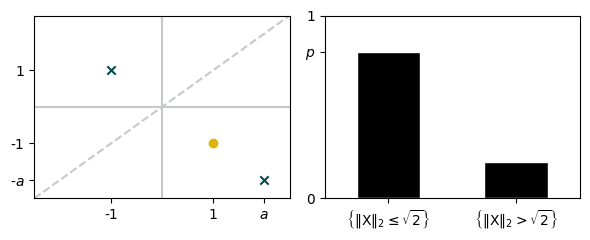

In [4]:
make_nocollapse()

We will not go into much detail here; see \[Hol24, section 3.1\] for more. What is important is that under a typical surrogate loss such as the usual binary logistic loss, for any $a > 1$, it is always possible to take $p$ close enough to $1$ such that $s_{1}$ is the unique solution in terms of the expected surrogate loss, also in agreement with the error probability $\mathcal{E}(\cdot)$. On the other hand, both the *maximum* and *minimum* losses (i.e., worst-case and best-case event over random draw of $(\mathsf{X},\mathsf{Y})$) prefer $s_{2}$ over $s_{1}$, and thus disagree with $\mathcal{E}(\cdot)$. One-sided criteria can be designed to put as much weight on the loss tails (either left or right tails, but not both), and thus such criteria can naturally be designed to disagree with $\mathcal{E}(\cdot)$, meaning that the solution sets cannot have any overlap (i.e., no collapse). This again is an overly simplistic example meant only to show that collapse is not a universal phenomenon. Criterion design in machine learning and the related pitfalls and tradeoffs are still rather unexplored, and an interesting direction for future research.

___

## In conclusion

Having made it this far, we hope that the reader has become familiar with the notion of learning criteria as a means of quantifying what a "good" loss distribution is. We also hope that the reader has been convinced that in designing machine learning systems which behave as we desire, learning criteria play a very important role, which is qualitatively distinct from that of loss functions.

Just as choosing a loss function is non-trivial, criterion choice is also non-trivial, and tradeoffs are unavoidable. To make gains in certain metrics, sometimes other metrics must be sacrificed; these tradeoffs are fundamental. What is important is that we understand that these tradeoffs exist, make our decision-making process as transparent as possible, and do our best to ensure that criterion choice is properly aligned with what we actually want to achieve. In some cases, what we want to achieve may be unrealizable, and elucidating tradeoffs between criteria is an important future direction for machine learning research that can help guide us towards more reasonable expectations. For the interested reader, the following three recent surveys provide a useful initial reference on learning criteria.

- [A Survey of Learning Criteria Going Beyond the Usual Risk](https://www.jair.org/index.php/jair/article/view/15000), Holland and Tanabe, JAIR 73:781-821, 2023.
- [Rank-Based Decomposable Losses in Machine Learning: A Survey](https://ieeexplore.ieee.org/document/10184478), Shu et al., IEEE PAMI 45:13599-13620, 2023.
- [Risk-Adaptive Approaches to Stochastic Optimization: A Survey](https://epubs.siam.org/doi/10.1137/22M1538946), Royset, SIAM Review 67:3-70, 2025.

These papers are just a start. The sub-field of learning criteria is just starting to develop, and there is a lot of interesting work being done at present. Happy learning!

___

## Appendix

### References

#### Section 1
- \[Ven02\] Venables, W. N. and Ripley, B. D. (2002) Modern Applied Statistics with S. Fourth edition. Springer.
- \[Kol97\] Koltchinskii, V. I. (1997). M-estimation, convexity and quantiles. The Annals of Statistics, pages 435-477.
- \[Rou84\] P.J. Rousseeuw. (1984) Least Median of Squares Regression. Journal of the American Statistical Association, 79(388):871-880. Taylor & Francis.
- \[RL87\] P.J. Rousseeuw and A.M. Leroy. Robust Regression and Outlier Detection. John Wiley & Sons, New York, 1987.

#### Section 2
- \[Bar19\] Barron, J. T. (2019). A general and adaptive robust loss function. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pages 4331-4339.
- \[BJL15\] Brownlees, C., Joly, E., and Lugosi, G. (2015). Empirical risk minimization for heavy-tailed losses. The Annals of Statistics, 43(6):2507-2536.
- \[Hol22\] Holland, M. J. (2022) Learning with risks based on M-location. Machine Learning, 111:4679-4718.
- \[Hol23\] Holland, M. J. (2023) Flexible risk design using bi-directional dispersion. In AISTATS 2023, volume 206 of Proceedings of Machine Learning Research, pages 1586-1623.
- \[Kol97\] Koltchinskii, V. I. (1997). M-estimation, convexity and quantiles. The Annals of Statistics, pages 435-477.
- \[LBSS21\] Li, T., Beirami, A., Sanjabi, M., and Smith, V. (2021). Tilted empirical risk minimization. In The 9th International Conference on Learning Representations (ICLR).
- \[LPS20\] Lee, J., Park, S., and Shin, J. (2020). Learning bounds for risk-sensitive learning. In Advances in Neural Information Processing Systems 33 (NeurIPS 2020), pages 13867-13879.
- \[RU00\] Rockafellar, R. T. and Uryasev, S. (2000). Optimization of conditional value-at-risk. Journal of Risk, 2:21-42.
- \[ZDKR21\] Zhai, R., Dan, C., Kolter, J. Z., and Ravikumar, P. (2021). DORO: Distributional and outlier robust optimization. In 38th International Conference on Machine Learning (ICML), volume 139 of Proceedings of Machine Learning Research, pages 12345-12355.

#### Section 3
- \[DN19\] Duchi, J. and Namkoong, H. (2019). Variance-based regularization with convex objectives. Journal of Machine Learning Research, 20(68):1-55.
- \[GKL18\] Gotoh, J.-y., Kim, M. J., and Lim, A. E. (2018). Robust empirical optimization is almost the same as mean-variance optimization. Operations Research Letters, 46(4):448-452.
- \[Hol24\] Holland, M. J. (2024) Criterion Collapse and Loss Distribution Control. In 41st International Conference on Machine Learning (ICML), volume 235 of Proceedings of Machine Learning Research, pages 18547-18567.
- \[LPS20\] Lee, J., Park, S., and Shin, J. (2020). Learning bounds for risk-sensitive learning. In Advances in Neural Information Processing Systems 33 (NeurIPS 2020), pages 13867-13879.
- \[MP09\] Maurer, A. and Pontil, M. (2009). Empirical Bernstein bounds and sample variance penalization. In Proceedings of the 22nd Conference on Learning Theory (COLT).

___